In [1]:
# standard imports
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import joblib
import matplotlib.pyplot as plt

# display settings
pd.options.display.max_columns = 200


In [11]:
CSV_PATH = r"c:\Users\harsh\Downloads\Data_set.csv"  # your file
TARGET = "Bookings"  # target column
AGG_FREQ = "15min"   # 15 minute bins
LAGS = [1,2,3,4]     # 1..4 lags (past 15,30,45,60 min)
MODEL_PATH = "lgb_bookings_1step.pkl"
RANDOM_STATE = 42

print("CSV Path:", CSV_PATH)

CSV Path: c:\Users\harsh\Downloads\Data_set.csv


In [12]:
assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"
df = pd.read_csv(CSV_PATH)
print("raw shape:", df.shape)
display(df.head(2))


raw shape: (18000, 41)


,Date,Time,Area Name,Road/Intersection Name,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization,Incident Reports,...,Drivers' Earnings,Average Distance per Trip (km),Average Fare per Trip,Distance Travelled (km),latitude,longitude,h3_index,event name,event type,event importance
0,19-12-2023,18:45,Basavanagudi,Gandhi Bazaar Main Road,538.0,52.991,1.133,16.04,11.529,1,...,23540.126,4.977,122.761,1220.137,12.943,77.575,8986dd49a57ffff,Neighborhood Event Basavanagudi,No Event,0.0
1,19-12-2023,20:15,BTM Layout,Outer Ring Road,645.0,44.329,1.363,20.67,11.619,0,...,967.442,3.654,81.874,320.226,12.910,77.610,8986dd49027ffff,No Event,No Event,0.0


In [13]:
# make Datetime column if not present
if "Datetime" not in df.columns:
    if "Date" in df.columns and "Time" in df.columns:
        # some files have day-first; try default then dayfirst
        df["Datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str),
                                        errors="coerce")
    else:
        # try to find a datetime-like column
        found = None
        for c in df.columns:
            if "date" in c.lower() or "time" in c.lower() or "datetime" in c.lower():
                found = c
                break
        if found:
            df["Datetime"] = pd.to_datetime(df[found], errors="coerce")
        else:
            raise ValueError("No datetime column found. Please provide 'Date'+'Time' or a datetime column.")

# prefer h3_index as zone; fallback to Area Name; else create a single zone
if "h3_index" in df.columns and df["h3_index"].notna().sum() > 0:
    df["zone"] = df["h3_index"].astype(str)
elif "Area Name" in df.columns:
    df["zone"] = df["Area Name"].astype(str)
else:
    df["zone"] = "zone_0"

# basic cleaning
df = df.sort_values("Datetime").reset_index(drop=True)
print("Datetime range:", df["Datetime"].min(), "->", df["Datetime"].max())
print("Zones:", df["zone"].nunique())


Datetime range: 2023-12-19 18:45:00 -> 2025-12-18 17:15:00
Zones: 67


C:\Users\harsh\AppData\Local\Temp\ipykernel_9564\3830789056.py:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str),


In [14]:
# choose aggregation functions safely
def safe_mean(col):
    return (col.mean() if len(col.dropna())>0 else np.nan)

group_cols = ["zone", pd.Grouper(key="Datetime", freq=AGG_FREQ)]
agg_dict = {}

# ensure target exists
if TARGET not in df.columns:
    # fallback to first numeric column if Bookings missing
    numeric = df.select_dtypes(float).columns.tolist() + df.select_dtypes(int).columns.tolist()
    numeric = [c for c in numeric if c not in ["latitude","longitude"]]
    if not numeric:
        raise ValueError("No numeric columns to use as target. Please provide Bookings.")
    TARGET = numeric[0]
    print(f"TARGET not found; using fallback target: {TARGET}")

# columns we try to aggregate (if present)
cands = ["Completed Trips","Traffic Volume","Average Speed","Congestion Level",
         "Temperature","Drivers' Earnings","Distance Travelled (km)","event importance"]
for c in cands:
    if c in df.columns:
        agg_dict[c] = safe_mean

# always aggregate target (use mean to handle multiple rows inside same bin)
agg_dict[TARGET] = safe_mean

# event type: take most frequent / first
if "event type" in df.columns:
    agg_dict["event type"] = lambda s: s.dropna().iloc[0] if len(s.dropna())>0 else "No Event"
else:
    df["event type"] = "No Event"
    agg_dict["event type"] = lambda s: "No Event"

# run aggregation
agg = df.groupby(group_cols, observed=True).agg(agg_dict).reset_index()
agg = agg.rename(columns={"Datetime":"Datetime"})  # keep Datetime
print("Aggregated shape:", agg.shape)
display(agg.head(4))


Aggregated shape: (17332, 12)


,zone,Datetime,Completed Trips,Traffic Volume,Average Speed,Congestion Level,Temperature,Drivers' Earnings,Distance Travelled (km),event importance,Bookings,event type
0,8986d880d77ffff,2024-01-05 18:30:00,85.0,481.00000,47.121,16.321000,23.504,3519.747,513.369,0.000,112.000000,No Event
1,8986d880d77ffff,2024-01-07 18:45:00,241.0,1324.39895,32.500,42.127794,30.300,85825.040,1954.510,0.870,526.178051,Local
2,8986d880d77ffff,2024-01-09 18:30:00,91.0,466.00000,47.540,16.596000,23.281,2065.448,502.273,0.049,106.000000,No Event
3,8986d880d77ffff,2024-01-10 18:30:00,68.0,430.00000,47.211,16.581000,23.953,3276.945,558.085,0.000,98.000000,No Event


In [6]:
# time features (based on the bin time)
# time features (based on the bin time)
agg["time_idx"] = (agg["Datetime"].view("int64") // (15 * 60 * 1e9)).astype(int)
agg["hour"] = agg["Datetime"].dt.hour
agg["weekday"] = agg["Datetime"].dt.weekday
agg["is_weekend"] = (agg["weekday"] >= 5).astype(int)


# label encode zone and event type
le_zone = LabelEncoder()
agg["zone_lbl"] = le_zone.fit_transform(agg["zone"].astype(str))

le_event = LabelEncoder()
agg["event_lbl"] = le_event.fit_transform(agg["event type"].astype(str))

# build lag features per zone
agg = agg.sort_values(["zone","Datetime"]).reset_index(drop=True)
for lag in LAGS:
    agg[f"{TARGET}_lag{lag}"] = agg.groupby("zone")[TARGET].shift(lag)

# drop rows where we don't have lag data (cannot train without lags)
before = len(agg)
agg = agg.dropna(subset=[f"{TARGET}_lag{LAGS[0]}"])  # ensure at least first lag present
print(f"dropped {before - len(agg)} rows due to missing lags")

# Fill remaining small NaNs (if any) with group median (safe)
for col in [c for c in agg.columns if c.startswith(f"{TARGET}_lag")]:
    agg[col] = agg[col].fillna(agg.groupby("zone")[col].transform("median"))
    agg[col] = agg[col].fillna(0.0)

# final check target
agg = agg[~agg[TARGET].isna()].copy()
print("Prepared shape:", agg.shape)
display(agg.head(4))


dropped 67 rows due to missing lags
Prepared shape: (17265, 22)


/tmp/ipykernel_19/2598530060.py:3: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  agg["time_idx"] = (agg["Datetime"].view("int64") // (15 * 60 * 1e9)).astype(int)


,zone,Datetime,Completed Trips,Traffic Volume,Average Speed,Congestion Level,Temperature,Drivers' Earnings,Distance Travelled (km),event importance,Bookings,event type,time_idx,hour,weekday,is_weekend,zone_lbl,event_lbl,Bookings_lag1,Bookings_lag2,Bookings_lag3,Bookings_lag4
1,8986d880d77ffff,2024-01-07 18:45:00,241.0,1324.39895,32.500,42.127794,30.300,85825.040,1954.510,0.870,526.178051,Local,1894059,18,6,1,0,3,112.000000,164.355911,163.075325,161.794738
2,8986d880d77ffff,2024-01-09 18:30:00,91.0,466.00000,47.540,16.596000,23.281,2065.448,502.273,0.049,106.000000,No Event,1894250,18,1,0,0,4,526.178051,112.000000,163.075325,161.794738
3,8986d880d77ffff,2024-01-10 18:30:00,68.0,430.00000,47.211,16.581000,23.953,3276.945,558.085,0.000,98.000000,No Event,1894346,18,2,0,0,4,106.000000,526.178051,112.000000,161.794738
4,8986d880d77ffff,2024-01-12 22:45:00,53.0,93.00000,57.370,7.862000,25.192,5215.502,228.881,0.000,58.000000,No Event,1894555,22,4,0,0,4,98.000000,106.000000,526.178051,112.000000


In [7]:
# time-based split: last timestamp per zone will be held out for one-step test
# create a boolean indicating last available row per zone
agg["is_last_in_zone"] = agg.groupby("zone")["Datetime"].transform(lambda x: x == x.max())

# training rows: all rows that are NOT last_in_zone
train_df = agg[~agg["is_last_in_zone"]].copy()
test_df = agg[agg["is_last_in_zone"]].copy()  # one row per zone for one-step evaluation

print("Train rows:", len(train_df), "Test (one-step per zone):", len(test_df))

# features to use
features = [
    # lags
] + [f"{TARGET}_lag{lag}" for lag in LAGS] + [
    "Traffic Volume","Average Speed","Congestion Level","Temperature",
    "Drivers' Earnings","Distance Travelled (km)",
    "hour","weekday","is_weekend","zone_lbl","event_lbl"
]

# keep only features that exist
features = [f for f in features if f in train_df.columns]
print("Final feature set:", features)

X_train = train_df[features].fillna(0.0)
y_train = train_df[TARGET].values

X_test = test_df[features].fillna(0.0)
y_test = test_df[TARGET].values


Train rows: 17198 Test (one-step per zone): 67
Final feature set: ['Bookings_lag1', 'Bookings_lag2', 'Bookings_lag3', 'Bookings_lag4', 'Traffic Volume', 'Average Speed', 'Congestion Level', 'Temperature', "Drivers' Earnings", 'Distance Travelled (km)', 'hour', 'weekday', 'is_weekend', 'zone_lbl', 'event_lbl']


In [8]:
from lightgbm import early_stopping, log_evaluation

model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE
)

# split a small part of training for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.08, shuffle=False)

# ✅ FIXED fit() block
model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=50, verbose=True),
        log_evaluation(period=50)
    ]
)

# save model
import joblib
joblib.dump((model, le_zone, le_event, features, LAGS), MODEL_PATH)
print("✅ Model saved to", MODEL_PATH)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2637
[LightGBM] [Info] Number of data points in the train set: 15822, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 271.159274
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 51.2305	valid_0's l2: 5448.57
[100]	valid_0's l1: 47.7164	valid_0's l2: 5148.17
[150]	valid_0's l1: 47.437	valid_0's l2: 5162.55
Early stopping, best iteration is:
[114]	valid_0's l1: 47.5148	valid_0's l2: 5122.37
✅ Model saved to lgb_bookings_1step.pkl


One-step-per-zone MAE: 57.809


,zone,Datetime,Bookings,pred
0,8986d886ccfffff,2025-10-14 08:45:00,318.000000,296.310508
1,8986dd493cbffff,2025-10-17 20:15:00,1451.404379,1275.039665
2,8986d887653ffff,2025-10-20 17:00:00,138.000000,151.485052
3,8986d884cc7ffff,2025-11-02 17:30:00,49.000000,38.134984
4,8986dd48273ffff,2025-11-04 17:00:00,459.923074,345.680764
5,8986d884537ffff,2025-11-05 14:00:00,59.000000,62.818453
6,8986d88412fffff,2025-11-05 20:30:00,185.000000,143.081573
7,8986d886ecfffff,2025-11-06 10:15:00,46.000000,57.151106
8,8986d8b34abffff,2025-11-07 00:15:00,70.991934,83.913226
9,8986d895153ffff,2025-11-09 14:00:00,145.075920,213.309482


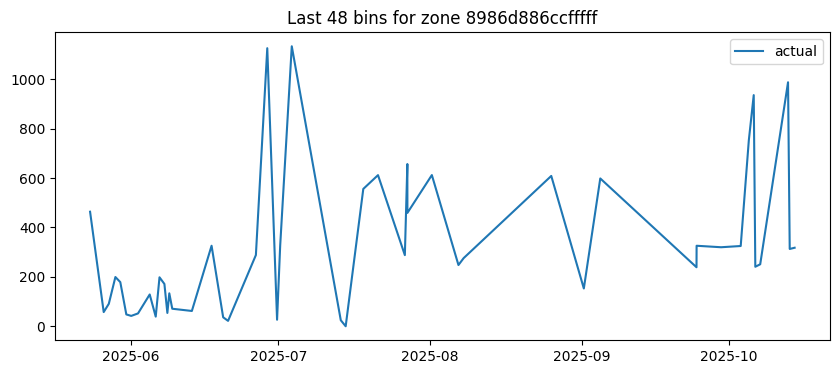

In [9]:
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"One-step-per-zone MAE: {mae:.3f}")

# show some samples
out = test_df[["zone","Datetime",TARGET]].copy()
out["pred"] = preds
out = out.sort_values("Datetime").reset_index(drop=True)
display(out.head(10))

# plot for a single zone (example)
example_zone = out["zone"].iloc[0]
z_df = agg[agg["zone"]==example_zone].sort_values("Datetime").tail(48)
plt.figure(figsize=(10,4))
plt.plot(z_df["Datetime"], z_df[TARGET], label="actual")
plt.title(f"Last 48 bins for zone {example_zone}")
plt.legend()
plt.show()


In [10]:
# Build input rows for next 15-min step for each zone
rows = []
for z in agg["zone"].unique():
    zdata = agg[agg["zone"]==z].sort_values("Datetime")
    last_row = zdata.iloc[-1]
    # create new row dict
    new = {}
    # time features for next step
    next_time = last_row["Datetime"] + pd.Timedelta(AGG_FREQ)
    new["Datetime"] = next_time
    new["hour"] = next_time.hour
    new["weekday"] = next_time.weekday()
    new["is_weekend"] = 1 if new["weekday"]>=5 else 0
    # event and zone encodings
    new["zone_lbl"] = le_zone.transform([z])[0]
    # event_lbl: assume same event type continues (safe)
    new["event_lbl"] = le_event.transform([ last_row.get("event type", "No Event") ])[0] if hasattr(le_event, "classes_") else 0
    # copy available numeric features from last_row (traffic, temp, etc.)
    for c in ["Traffic Volume","Average Speed","Congestion Level","Temperature","Drivers' Earnings","Distance Travelled (km)"]:
        if c in last_row.index:
            new[c] = last_row[c]
    # lags: shift the window by 1 (lag1 becomes last value, lag2 becomes last lag1, etc.)
    for lag in LAGS:
        col = f"{TARGET}_lag{lag}"
        if col in last_row.index:
            # for next-step input, lag1 should be last actual, lag2 last lag1, etc.
            if lag == 1:
                new[col] = last_row[TARGET]  # most recent actual
            else:
                new[col] = last_row.get(f"{TARGET}_lag{lag-1}", 0.0)
    rows.append(new)

next_df = pd.DataFrame(rows).fillna(0.0)

# ensure same feature columns order
X_next = next_df[features].fillna(0.0)
next_preds = model.predict(X_next)

forecast = pd.DataFrame({
    "zone": agg["zone"].unique(),
    "next_time": next_df["Datetime"],
    "pred_bookings_15min": np.round(next_preds,2)
})
display(forecast.head(20))


,zone,next_time,pred_bookings_15min
0,8986d880d77ffff,2025-12-03 14:30:00,199.33
1,8986d882c0bffff,2025-12-08 23:00:00,95.85
2,8986d882e3bffff,2025-12-13 08:30:00,99.07
3,8986d88412bffff,2025-12-11 08:45:00,598.82
4,8986d88412fffff,2025-11-05 20:45:00,143.14
5,8986d88440bffff,2025-12-06 08:15:00,122.60
6,8986d88449bffff,2025-12-10 10:00:00,445.28
7,8986d884537ffff,2025-11-05 14:15:00,62.82
8,8986d88454bffff,2025-12-12 00:15:00,597.07
9,8986d88454fffff,2025-12-11 20:15:00,420.88


In [11]:
from sklearn.metrics import mean_absolute_error, r2_score

# predictions on validation part
y_pred_val = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f"Validation MAE: {mae:.2f}")
print(f"Validation R²: {r2:.3f}")


Validation MAE: 47.51
Validation R²: 0.866


                 Datetime     Bookings  Predicted_Bookings
17322 2025-10-06 00:45:00    13.000000          119.585603
17323 2025-10-26 22:45:00    66.000000          107.383623
17324 2025-11-02 08:30:00    18.000000          194.440633
17325 2025-11-04 22:45:00    61.000000           63.169310
17326 2025-11-07 18:15:00    88.000000           72.254841
17327 2025-11-14 18:15:00    92.000000          394.943118
17328 2025-11-27 08:30:00  1162.151874          255.326557
17329 2025-12-01 20:00:00   141.019104          744.797673
17330 2025-12-07 08:30:00  1080.528997           97.155177
17331 2025-12-13 20:00:00   173.002194          209.849237


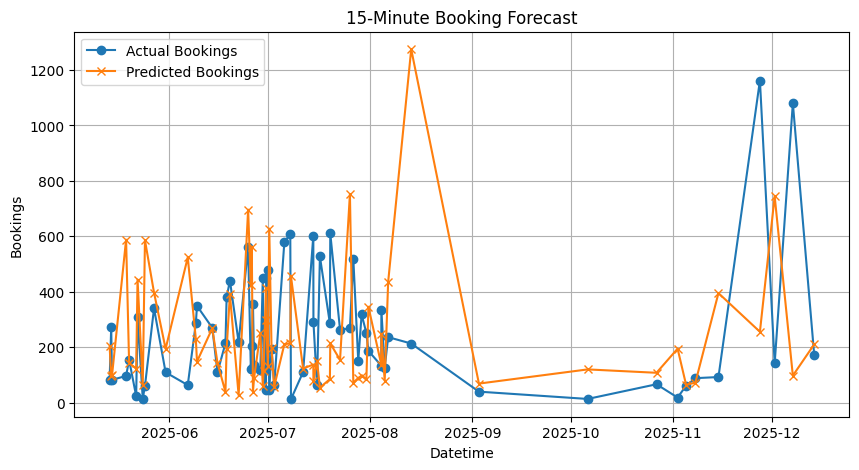

In [12]:
# ✅ Step 2: Predict on the most recent 15-minute slots
future_pred = model.predict(X_test)

# Create a new DataFrame for predicted results
pred_df = agg.tail(len(future_pred)).copy()
pred_df["Predicted_Bookings"] = future_pred

# Combine recent actuals + predictions for comparison
compare_df = pred_df[["Datetime", "Bookings", "Predicted_Bookings"]].tail(10)
print(compare_df)

# Optional: plot actual vs predicted bookings
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(pred_df["Datetime"], pred_df["Bookings"], label="Actual Bookings", marker="o")
plt.plot(pred_df["Datetime"], pred_df["Predicted_Bookings"], label="Predicted Bookings", marker="x")
plt.title("15-Minute Booking Forecast")
plt.xlabel("Datetime")
plt.ylabel("Bookings")
plt.legend()
plt.grid(True)
plt.show()


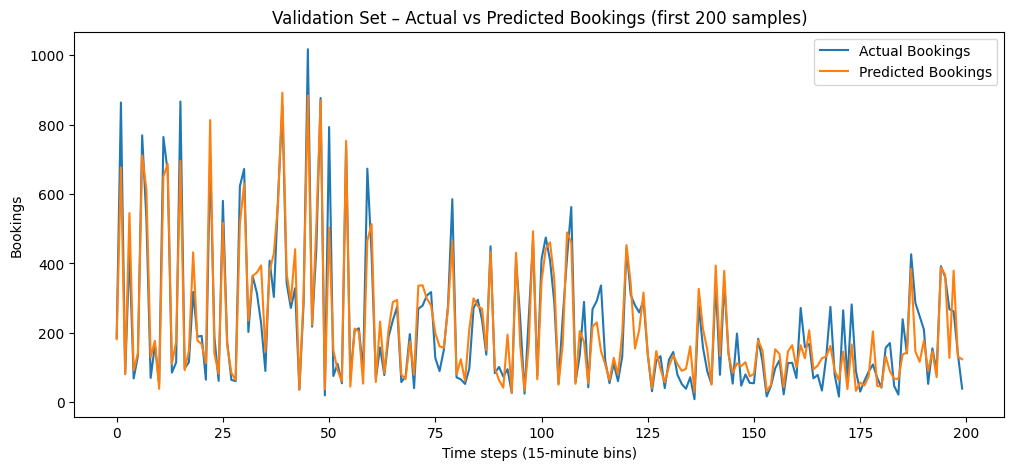

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_val[:200], label="Actual Bookings")
plt.plot(y_pred_val[:200], label="Predicted Bookings")
plt.legend()
plt.title("Validation Set – Actual vs Predicted Bookings (first 200 samples)")
plt.xlabel("Time steps (15-minute bins)")
plt.ylabel("Bookings")
plt.show()


In [14]:
# ✅ Save your 15-minute forecast to a CSV file
forecast.to_csv("forecast_15min_predictions.csv", index=False)
print("✅ Forecast CSV saved as forecast_15min_predictions.csv")


✅ Forecast CSV saved as forecast_15min_predictions.csv


In [15]:
# Save validation results (actual vs predicted)
val_results = pd.DataFrame({
    "Actual_Bookings": y_val,
    "Predicted_Bookings": y_pred_val
})

# Optionally, include residual error and time index
val_results["Error"] = val_results["Actual_Bookings"] - val_results["Predicted_Bookings"]

# Save to CSV
val_results.to_csv("validation_results.csv", index=False)
print("✅ Saved validation_results.csv with", len(val_results), "rows")


✅ Saved validation_results.csv with 1376 rows


In [1]:
import nbconvert
import os

# Get the current notebook's path
notebook_path = os.path.abspath('notebookf88a7e9de8.ipynb')

# Configure the HTML exporter
html_exporter = nbconvert.HTMLExporter()

# Convert the notebook
output, resources = html_exporter.from_filename(notebook_path)

# Write the HTML file
html_file = notebook_path.replace('.ipynb', '.html')
with open(html_file, 'w', encoding='utf-8') as f:
    f.write(output)

print(f"Notebook has been exported to HTML at: {html_file}")

Notebook has been exported to HTML at: c:\Users\harsh\Downloads\notebookf88a7e9de8.html


In [ ]:
# Save the aggregated zone-level data
agg.to_csv("aggregated_zone_data.csv", index=False)
print("✅ Saved: aggregated_zone_data.csv with shape", agg.shape)

NameError: name 'agg' is not defined